In [ ]:
report_date = '2021-08-23 00:00:00'

In [ ]:
# !pip install pandas
# !pip install pymssql
# !pip install sklearn
#!pip install pendulum

In [ ]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import curve_fit
import datetime
import pendulum
import pytz

In [ ]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
            # autocommit=True
        )

In [ ]:
def read_sql(query):
    return pd.read_sql(query, con=ms_sql_con(), parse_dates=None)

In [ ]:
def spent_time_vs_duration():
    print('spent time vs audio record duration')    
    df.plot(x="duration", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [ ]:
def spent_time_vs_date():
    print('spent time on timeline')
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()
    df.plot(x="time_int", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [ ]:
def coef():
    x_train = np.array(df.duration).reshape(-1, 1)
    y_train = np.array(df.time).reshape(-1, 1)
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_train)
    plt.scatter(x_train, y_train,  color='gray')
    plt.plot(x_train, y_pred, color='red', linewidth=2)
    plt.show()
    print('linear regression coef', model.coef_)
    return model.coef_[0][0]

In [ ]:
def performance():
    
   
    print('performance: seconds of recognized audio per 10 min')
    counter = [0 for _ in range(int(df.time_int.max()/600))]
    
    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    plt.plot([x for x in range(len(counter))], counter, 'o', color='red', linewidth=2)
    plt.show()
    print([int(c) for c in counter])

In [ ]:
def perf_cores():

    print('performance by cores count:')
    
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()

    counter = [[] for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append([])
        counter[cell].append(row.cores)

    cores = np.nan_to_num( [np.mean(c) for c in counter] )

    counter = [0 for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    
    pc = pd.DataFrame([cores, counter]).T
    pc.columns = ['cores', 'time']
    pc = pd.DataFrame(pc.groupby('cores').mean())
    pc.reset_index(level=0, inplace=True)
    
    plt.plot(pc.cores, pc.time, 'o', color='red', linewidth=2)
    plt.show()

In [ ]:
def cores_to_performance_calculated(report_date):
    
    print('cores count performance calculated:')
    
    query = "select cores, time, duration"
    query += " from perf_log "
    query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
    df = read_sql()
    df['td'] = df.time/df.duration
    df['perf'] = df.time/df.duration/df.cores
    df.drop(['duration','time'], axis=1, inplace=True)

    #meantd = df.groupby(df.cores).mean()
    #meantd.reset_index(level=0, inplace=True)
    #plt.plot(meantd.cores, meantd.td, 'o')

    #mediantd = df.groupby(df.cores).median()
    #mediantd.reset_index(level=0, inplace=True)
    #plt.plot(mediantd.cores, mediantd.td, 'o')

    mediantd = df.groupby(df.cores).median()
    mediantd.reset_index(level=0, inplace=True)
    plt.plot(mediantd.cores, mediantd.perf, 'o')

In [ ]:
def reco_prognose():
    query = "select sum(duration) from queue"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    queued_duration = float(df_queued.iloc[0])
    time_prognose = queued_duration * performance_coef
    print('recognize time prognose:', int(time_prognose), 'sec')
    print('or', int(time_prognose/60), 'min')
    print('or', int(time_prognose/60/60), 'h')
    print('or', int(time_prognose/60/60/24), 'd')

In [ ]:
def colorator(source_id):
    return 'red' if source_id == 1 else 'green'

In [ ]:
def earliest_records():
    print('earliest records')
    query = "select source_id, min(record_date) from queue group by source_id order by source_id;"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    print(df_queued)

In [ ]:
#query = "select event_date, cpu, time, duration from perf_log where step = 1 and duration<400 and time > 1000;"
#query = "select cpu, count(cpu) as cnt, sum(time) as time_sum from perf_log where step = 2 and time > 1000 group by cpu order by cpu;"
#query = "select event_date, time as time_sum from perf_log where step = 2 and cpu = 3 order by event_date;"

In [ ]:
def plot_cpu_usage():
    df.groupby(['cpu']).sum().plot(y = ['time'], kind="bar")

In [ ]:
def queue_time_vs_date():
    queue['color'] = queue['source_id'].apply(colorator)
    
    q_a = queue[queue.source_id == 1]
    q_b = queue[queue.source_id == 2]
    
    ratio = max(queue.queued_seconds_from_now) / max(queue.recorded_seconds_from_now) * 10
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
    
    ax.scatter(
        q_a.queued_seconds_from_now, 
        q_a.recorded_seconds_from_now, 
        color=q_a['color'],
        label="call",
         marker = 'x'
    )
    ax.scatter(
        q_b.queued_seconds_from_now, 
        q_b.recorded_seconds_from_now, 
        color=q_b['color'],
        label="mrm",
        marker = '.'
    )
    currentdate = datetime.datetime.today()
    currentdate = currentdate.strftime('%Y.%m.%d %H:%M:%S')
    #datetime.datetime.strptime(df, f_0).strftime(f_1)
    ax.set_title('Очередь ' + currentdate, fontsize=18)

    # Set common labels
    ax.set_xlabel('Добавлено, сек. назад', fontsize=18)
    ax.set_ylabel('Записано, сек. назад', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.savefig('queue.png')

In [ ]:
query = "select event_date, cpu, time, duration, source_id, cores"
query += " from perf_log "
#query += " where cores = 9 and step = 2 and event_date > '2021-03-12 15:27:00' and time > 5;"
query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
df = read_sql(query)
df['color'] = df['source_id'].apply(colorator)
spent_time_vs_duration()
performance_coef = coef()
#print('9 cores')
spent_time_vs_date()
performance()
perf_cores()
plot_cpu_usage()
reco_prognose()
earliest_records()

query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

In [ ]:
query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

In [ ]:
query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

In [ ]:
#cores_to_performance_calculated()

In [ ]:
# queue
query = "SELECT column_name FROM information_schema.columns WHERE table_name='queue';"
queue = read_sql(query)
queue

In [ ]:
query = "SELECT version, record_date, filename FROM queue order by record_date;"
queue = read_sql(query)
queue

In [ ]:
# queue by cpu
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by cpu_id;"
queue = read_sql(query)
queue

In [ ]:
# queue by cpu
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by count(linkedid) desc;"
queue = read_sql(query)
queue

In [ ]:
# queue by cpu
print(datetime.datetime.now().astimezone(pytz.timezone('Europe/Moscow')))
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by cpu_id;"
queue = read_sql(query)
queue

In [ ]:
# queue by cpu
print(datetime.datetime.now().astimezone(pytz.timezone('Europe/Moscow')))
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by cpu_id;"
queue = read_sql(query)
queue

### scratch

In [64]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='perf_log';"
df = read_sql(query)
df

,column_name
0,event_date
1,step
2,cpu
3,duration
4,linkedid
5,source_id
6,cores
7,time
8,file_name


In [70]:
start_date = '2021-09-07 08:24:00'
end_date = '2022-08-25 00:00:00'

query = "select file_name, cpu, time, duration"
query += " from perf_log "
query += " where step = 2 and event_date > '"+start_date+"' and time > 5"
query += " and event_date < '"+end_date+"';"
df = read_sql(query)
df['td'] = df.duration/df.time
len(df)

61

<AxesSubplot:title={'center':'Транскрибация аудиофайлов'}, xlabel='Ядро', ylabel='Количество файлов'>

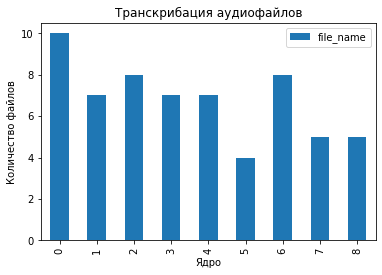

In [71]:
#df.groupby(['cpu']).count().plot(y = ['file_name'], kind="bar")
df.groupby('cpu').count().plot(
    y = ['file_name'], 
    kind="bar", 
    xlabel='Ядро', 
    ylabel='Количество файлов', 
    title='Транскрибация аудиофайлов'
)

In [72]:
df.drop(['file_name', 'time', 'duration'], axis=1, inplace = True)

<AxesSubplot:title={'center':'Медианная производительность транскрибации'}, xlabel='cpu', ylabel='Производительность'>

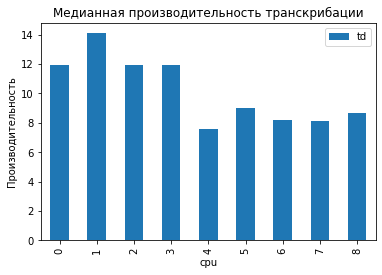

In [73]:
df.groupby('cpu').median().plot(
    y = ['td'], 
    kind="bar", 
    xlabel='cpu', 
    ylabel='Производительность', 
    title='Медианная производительность транскрибации'
)

<AxesSubplot:title={'center':'Средняя производительность транскрибации'}, xlabel='cpu', ylabel='Производительность'>

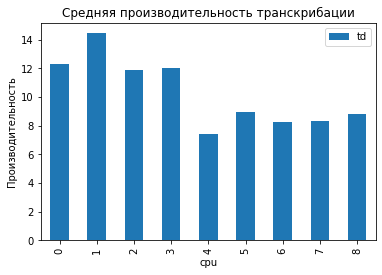

In [74]:
df.groupby('cpu').mean().plot(
    y = ['td'], 
    kind="bar", 
    xlabel='cpu', 
    ylabel='Производительность', 
    title='Средняя производительность транскрибации'
)

### check transcribations

In [ ]:
# queue
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
queue = read_sql(query)
queue

In [ ]:
query = "select cpu_id, source_id, linkedid, start, side, text"
query += " from transcribations "
query += " where transcribation_date > '2021-09-07 08:24:00' "
query += " and transcribation_date < '2022-09-06 20:10:00' "
query += " and duration > 5 and source_id = 1"
#query += " and audio_file_name = 'in_78632641676_2021-08-23-12-11-03rxtx.wav'"
query += " order by source_id, cpu_id, linkedid, start;"
df = read_sql(query)
df

In [ ]:
for idx, row in df.iterrows():
    print(row.source_id, row.linkedid, row.text)

# DROP WRONG

In [ ]:
start_date = '2021-08-23 15:10:00'
end_date = '2021-08-24 15:32:00'
query = "select top 100 source_id, cpu_id, linkedid, start, side, text"
#query = "select file_name, cpu"
query += " from transcribations "
query += " where cpu_id < 2"
query += " and source_id = 1"
query += " and transcribation_date > '"+start_date+"' "
query += " and transcribation_date < '"+end_date+"' "
query += " and duration > 5"
#query += " and audio_file_name = 'in_78632641676_2021-08-23-12-11-03rxtx.wav'"
query += " order by linkedid, start;"
df = read_sql(query)
df

### queue

In [ ]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
queue = read_sql(query)
queue

In [ ]:
### server debug

In [ ]:
batch_size = 100
cpu_id = 11
past_in_minutes = pendulum.now().add(minutes=-6).strftime('%Y-%m-%d %H:%M:%S')
sql_query = "select top "+str(batch_size)+" filepath, filename, duration, source_id, "
sql_query += "record_date, src, dst, linkedid, file_size, date from queue "
sql_query += "where cpu_id='" + str(cpu_id) + "' "
sql_query += "and ( (source_id = '2' and record_date < '" + past_in_minutes + "') or not source_id = '2' ) "
#sql_query += "order by ISNULL(record_date, 0) desc, record_date, linkedid, filename;"
sql_query += "order by record_date, filename;"

queue = read_sql(sql_query)
queue